# Introduction

**Data sourced from:** [BHANUPRATAP BISWAS Superstore Sales Data](http://www.kaggle.com/datasets/bhanupratapbiswas/superstore-sales/data)

**Data licensing:** [ODC public domain](http://opendatacommons.org/licenses/pddl/1-0/)- intended to allow you to freely share, modify, and use this work for any purpose and without any restrictions.

**Data collection:** This dataset contains data from January 3, 2015- January 5, 2019.


**About the data:**

"Superstore Sales" refers to the sales data and performance of a large retail store offering a wide range of merchandise. Analyzing sales data helps stakeholders to understand store performance, identify trends, and make data driven business decisions. 

Superstores are known for:
* extensive inventory 
* competitive pricing
* one-stop shopping experience.

**Key aspects of superstore sales analysis:**

1. Sales **Revenue**: 
* Sales revenue over time helps provides insights into the financial performance of the superstore. 
* Helps identify peak seasons and periods of high or low sales.

2. Sales by **Product Category**: 
* Helps understand which categories are driving revenue and which may require improvement.

3. Sales by **Region**: 
* Helps identify the best-performing stores and areas for expansion or improvement.

4. Sales by **Customer Segments**: 
* Sales patterns among different customer segments can inform targeted marketing strategies and customer engagement.

5. Sales **Trends**: 
* Trends over time, such as monthly or seasonal variations can help in inventory management and marketing planning.

6. **Product** Performance: 
* Individual product sales help identify popular products, slow-moving items, and potential stockouts.

7. Customer **Behavior**: 
* Purchase frequency, average transaction value, and repeat purchases, can provides insights into customer preferences and loyalty.

8. **Promotions** and Discounts: 
* Evaluating the impact of promotions and discounts on sales can help optimize marketing strategies.

9. Sales **Forecasting**: 
* Using historical sales data, stakeholders can forecast future sales, plan inventory levels, and make data-driven decisions.

**Business Task:** Analyze sales data to gain insights into store profitability, inventory turnover and customer trends to gain a comprehensive view of overall business performance.

**Stakeholders Include:**
* Store owners
* Store managers
* Analyst teams

# Process

In [ ]:
#upload file and change data types
library(readr)
superstore_sales <- read_csv("/kaggle/input/superstore-sales/superstore_final_dataset (1).csv",
                             col_types = cols(Order_Date = col_date(format = "%d/%m/%Y"),
                                              Ship_Date = col_date(format="%d/%m/%Y")))

library(tidyverse) # metapackage of all tidyverse packages

In [ ]:
#View first rows of dataset
head(superstore_sales)

In [ ]:
#View summary statistics of data frame
summary(superstore_sales)

In [ ]:
#View data types and elements
str(superstore_sales)

In [ ]:
#Check for null values
sapply(superstore_sales, function(x) sum(is.na(x)))
    

In [ ]:
#Drop rows with null values
superstore_sales %>% 
  drop_na()

# Analysis

## Sales Revenue

In [ ]:
#distribution of sales
superstore_sales %>%
select(Order_Date, Sales) %>%
group_by(Order_Date) %>% 
  summarise(daily_sales = sum(Sales)) %>%  #get total sales for each date
ggplot(aes(log(daily_sales))) + geom_histogram(color='white',bins=30) + ylab("Frequency") + ggtitle("Distribution of Sales") +
theme(plot.title = element_text(hjust=0.5, face='bold')) 

superstore_sales %>% #create new df to group sales by month 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Month, Order_Year, Sales) %>%
group_by(Order_Month, Order_Year) %>%
summarise(sum=sum(Sales), .groups = "drop_last") %>%
ggplot(aes(Order_Month, sum)) + geom_boxplot() + ylab("Total Sales") + xlab("Order Month") + ggtitle("Distribution of Monthly Sales") + theme(plot.title=element_text(face='bold'))



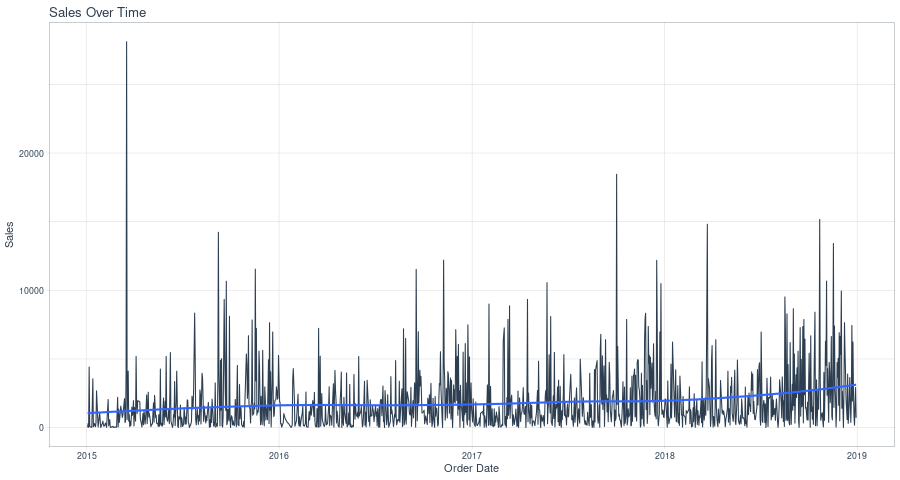

We see an upward trend in overall sales from 2015-2018

## Product Category Sales

In [ ]:
#total sales by product category
library(cowplot)

p1<- superstore_sales %>%
ggplot(aes(Category, Sales, fill=Category)) + geom_col() + 
scale_y_continuous(labels=scales::comma) +
ggtitle("Total Sales") +
theme(plot.title=element_text(hjust=0.5))+ scale_fill_brewer(palette="Paired")

p2 <- superstore_sales %>%
ggplot(aes(Category, fill=Category)) + geom_bar() + scale_fill_brewer(palette="Paired") + ggtitle("Total Orders") +
theme(axis.title.y=element_blank(), plot.title=element_text(hjust=0.5))

plot_grid(p1 + theme(legend.position = "none"),
          p2 + theme(legend.position= "none")
         )

Technology has the highest sales. Office supplies accounts for the lowest total sales, but has the highest volume of sales overall.

## Regional Sales

In [ ]:
#mean sales by region
superstore_sales %>%
select(Region, Sales) %>%
group_by(Region) %>%
summarise(mean_sale=mean(Sales)) %>%
ggplot(aes(Region, mean_sale, fill=Region)) + geom_col() +
ggtitle("Mean Sales by Region") + theme(plot.title=element_text(hjust=0.5), legend.position = 'none') +
ylab("Sales")


#Top selling states by total revenue
topstates <- head(superstore_sales %>%
                 select(State, Sales) %>%
                 group_by(State) %>%
                 summarise(sum=sum(Sales)) %>%
                 arrange(desc(sum)), 10)
topstates %>%
mutate(State=fct_reorder(State, sum)) %>%
ggplot(aes(sum, State, fill=State)) + geom_col() + 
scale_x_continuous(labels=scales::comma) +
xlab("Total Sales") + ylab("State") + ggtitle("Top Selling States") +
theme( plot.title = element_text(hjust=0.5), 
      legend.position = "none",
     panel.grid.major=element_blank()) + scale_fill_brewer(palette="BrBG")

#top selling cities by total revenue
topcities <- head(superstore_sales %>% #get top 10 cities with highest overall sales
                 select(City, Sales) %>%
                  group_by(City) %>%
                  summarise(sum=sum(Sales)) %>%
                  arrange(desc(sum)), 10)

topcities %>%
mutate(City=fct_reorder(City, sum)) %>%
ggplot(aes(sum,City, fill=City)) + geom_col() + xlab("Total Sales") +
ggtitle("Top Selling Cities") + 
theme(panel.grid.major = element_blank(), legend.position = "none", plot.title=element_text(hjust=0.5)) +
scale_fill_brewer(palette="RdBu")



The southern region has the highest average sales, but California and New York state are sales leaders.

## Customer Segments 

In [ ]:
#total number of orders by segment
percent_sales<- superstore_sales %>%
group_by(Segment) %>%
summarise(count=n()) %>%
mutate(percent_in_group=round((count/sum(count))*100, digits = 1),
       fraction=count/sum(count),
       ymax=cumsum(fraction),
       ymin=c(0, head(ymax, n=-1)),
       labelPosition=(ymax+ymin)/2,
       label=paste0(Segment, "\n ", percent_in_group, '%')) 

percent_sales %>%
ggplot(aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=Segment)) + geom_rect() + 
geom_label(x=3.5, aes(y=labelPosition, label=label, size=3)) + 
coord_polar(theta = "y") + theme_void() + scale_fill_brewer(palette="Paired") +
theme(legend.position='none', plot.title=element_text(hjust=0.5, vjust=-4, face='bold')) + 
ggtitle("Number of Orders by Segment")

#Average sale by segment
superstore_sales %>%
select(Segment, Sales) %>%
group_by(Segment) %>%
summarise(mean_segment=mean(Sales)) %>%
ggplot(aes(Segment, mean_segment, fill=Segment)) + geom_col() + 
ggtitle('Mean Sales by Segment') + ylab("Sales") +
theme(plot.title=element_text(hjust=0.5), legend.position = 'none')



Consumers account for over 50% of sale volume, showing they are the target market, despite having the lowest average sale. While home office has the highest average sale, they are coming into the store less frequently, or are not repeat customers.

## Sales Trends

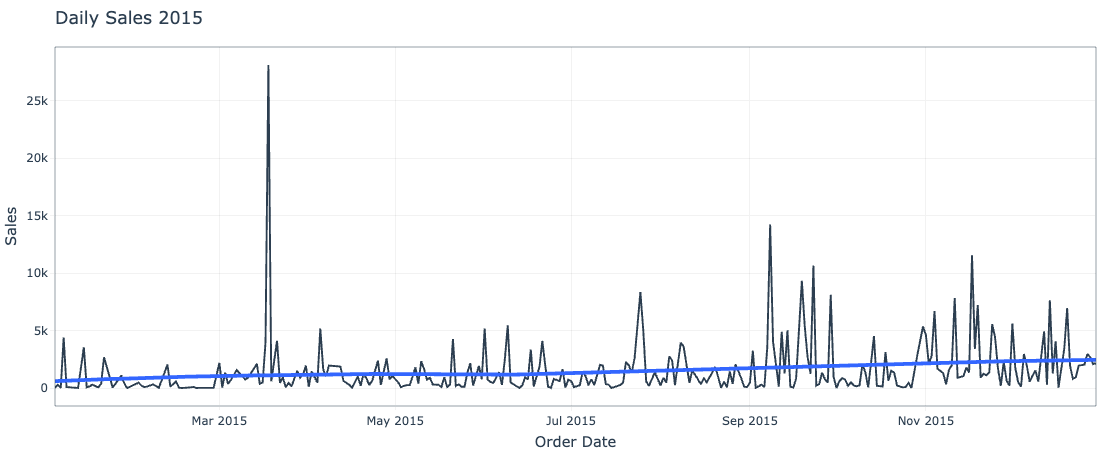
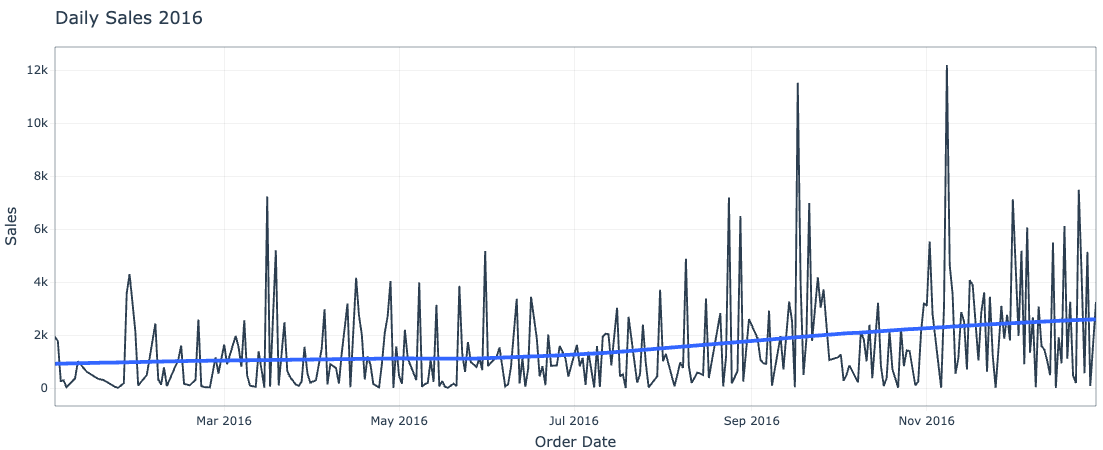
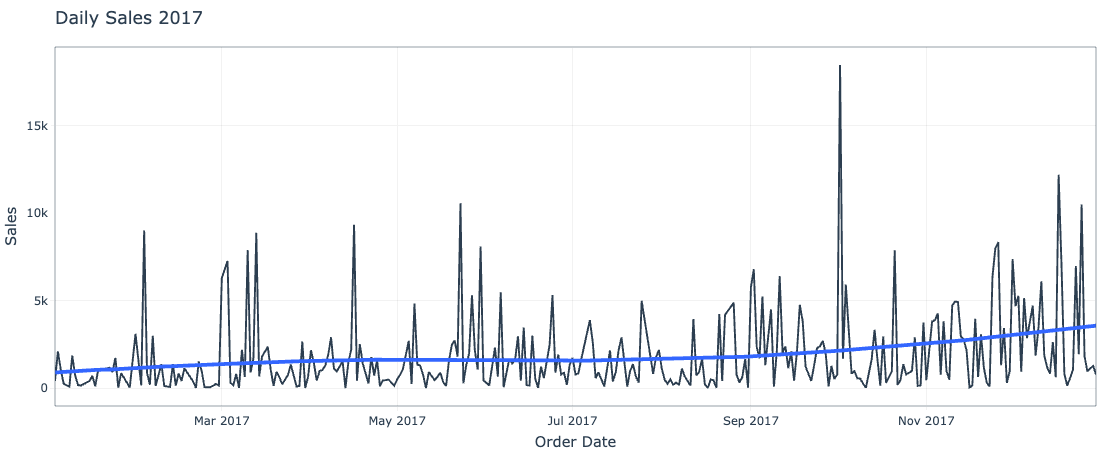
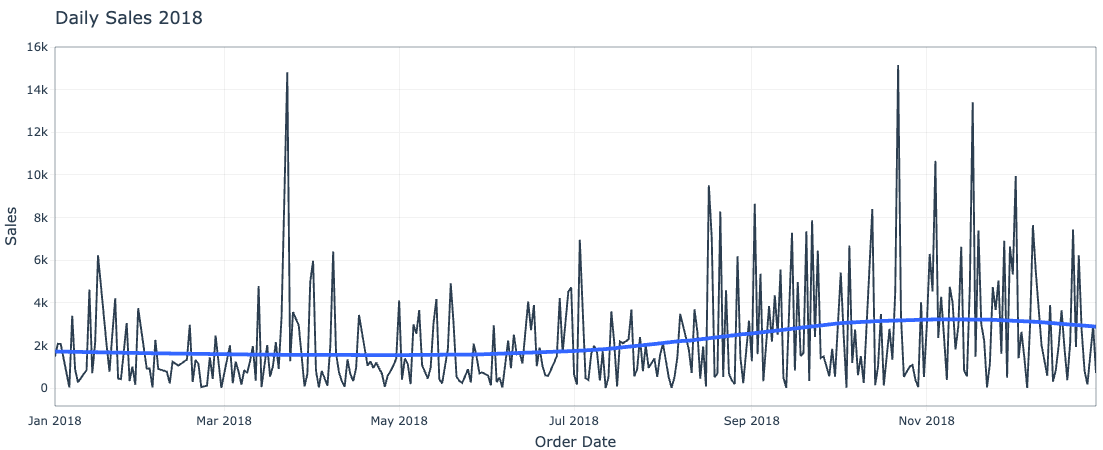

In [ ]:
#Sales over time by year
superstore_sales %>% #create new df to group sales by month and year 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Month, Order_Year, Sales) %>%
group_by(Order_Month, Order_Year) %>%
summarise(sum=sum(Sales), .groups = "drop_last") %>%
ggplot(aes(Order_Month, sum, group=Order_Year)) + geom_line(aes(color=Order_Year), linewidth=0.5) +
ggtitle("Monthly Sales Over Time") + xlab("Order Month") + ylab("Sales") + labs(color="Order Year") + theme(plot.title = element_text(hjust=0.5))


Sales are consistently highest in March, September, and November, meaning this is when inventory should be well stocked. Sales have increased year to year, showing an upward trend in business.

In [ ]:
#category sales by time of year
superstore_sales %>% #create new df to group sales by month and year 
  separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
  select(Order_Month, Sales, Category) %>%
  group_by(Order_Month, Category) %>%
  summarise(sum=sum(Sales), .groups="drop_last") %>% 
  ggplot(aes(Order_Month, sum, group=Category)) + geom_line(aes(color=Category)) + 
scale_y_continuous(labels=scales::comma) + xlab("Order Month") + ylab("Total Sales") + ggtitle("Cateogry Sales Trends")

Technology sales have the highest lead in March and November, while Furniture sales are highest in September and December. Categories may have seasonality.

In [ ]:
#regional trends
superstore_sales %>% #create new df to group sales by month and year 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Month, Order_Year, Region, Sales) %>%
group_by(Order_Month, Order_Year, Region) %>%
summarise(sum=sum(Sales), .groups = "drop_last") %>%
ggplot(aes(Order_Month, sum, group=Order_Year)) + geom_line(aes(color=Order_Year), linewidth=0.5) + 
facet_wrap(~Region) + ggtitle("Regional Sales Trends") + ylab("Total Sales") + xlab("Order Month") + labs(color=" Order Year") +
theme(plot.title=element_text(face='bold'))

The eastern region has had the highest increase in sales, particularly in 2018. The western and southern regions have also showed a steady increase in sales. Central region growth should be further examined into possible causes for lower sales.

In [ ]:
#Segment trends
superstore_sales %>% #create new df to group sales by month and year 
  separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
  select(Order_Month, Segment, Sales) %>%
  group_by(Order_Month, Segment) %>%
  summarise(sum=sum(Sales), .groups = "drop_last") %>% 
  ggplot(aes(Order_Month, sum, group=Segment)) + geom_line(aes(color=Segment), linewidth=0.5) + ggtitle("Segment Sales Trends") + ylab("Total Sales") + xlab("Order Month") +
theme(plot.title=element_text(face='bold'))


The consumer segment has sales peaks in March, September and December. Corporate sales reach peak in November. Home office sales reach peaks in March and November.

## Product Performance

In [ ]:
top_products <- head(superstore_sales %>% 
                       select(Product_Name, Sales) %>% 
                       group_by(Product_Name) %>% 
                       summarise(sum=sum(Sales)) %>% 
                       arrange(desc(sum)), 10)

top_products %>%
mutate(Product_Name=fct_reorder(Product_Name, sum)) %>%
ggplot(aes(Product_Name, sum, fill=Product_Name)) + geom_col() + 
scale_x_discrete(labels=label_wrap_gen(30)) +
ylab("Total Sales") + xlab("Product Name") +
ggtitle("Top Selling Products") +
theme(legend.position = 'none', plot.title = element_text(hjust=0.5)) +
coord_flip()


Highest grossing products overall.

In [ ]:
#Slowest moving products
superstore_sales %>% 
                    select(Product_Name, Sales) %>% 
                       group_by(Product_Name) %>% 
                       summarise(Total_Sales=sum(Sales)) %>% 
                       arrange(Total_Sales) %>%
print(n=10)

These products could be removed from inventory to make room for higher sellers.

In [ ]:
#Top products by sale frequency
superstore_sales %>% 
  count(Product_Name, sort=TRUE, name="Number_of_orders") %>%
print(n=10)

These products are purchased with the highest frequency, and should remain at high inventory at all times.

## Customer Behavior

In [ ]:
#get top customers
superstore_sales %>% 
  count(Customer_Name, sort=TRUE, name="Number_of_Orders") %>% 
  print(n=10)
top_customers<- superstore_sales %>% #new df with top 5 customers
  filter(Customer_Name %in% c("William Brown", "Matt Abelman", "Paul Prost", "John Lee", "Chloris Kastensmidt", "Jonathan Doherty", "Seth Vernon", "Arthur Prichep", "Emily Phan", "Zuschuss Carroll"))
top_customers %>%
select(Customer_Name, Segment, Sales) %>%
group_by(Customer_Name, Segment) %>%
summarise(Average_Sale=mean(Sales), .groups="drop_last") %>% #get average sale
arrange(desc(Average_Sale))

top_customers %>%
group_by(Segment) %>% #segment distribution of highest repeat customers
summarise(count=n()) %>%
mutate(percent_in_group=round((count/sum(count))*100, digits=1), fraction=count/sum(count), ymax=cumsum(fraction), ymin=c(0, head(ymax, n=-1)),labelPosition=(ymax+ymin)/2,label=paste0(Segment, "\n ", percent_in_group, '%')) %>%
ggplot(aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=Segment)) + geom_rect() + geom_label(x=3.5, aes(y=labelPosition, label=label, size=3)) + coord_polar(theta = "y") + theme_void() + scale_fill_brewer(palette="Paired") + theme(legend.position='none', plot.title=element_text(hjust=0.5, vjust=-5, face='bold')) + 
ggtitle("Top 10 Customers Purchase Segmentation")

top_customers %>% #ship mode analysis of highest repeat customers
ggplot(aes(Ship_Mode, fill=Ship_Mode)) + geom_bar() + theme(legend.position = 'none', axis.title.x = element_blank(), plot.title = element_text(hjust=0.5)) + ggtitle("Top Customers Ship Mode Usage")


In the top customers breakdown, the majority are consumer sales at nearly 70%, which we can take to be the most loyal customers of the group, as well as the target market. The ship mode doesnt seem to be a big influence, as the majority still utilize standard class over faster shipping.

## Promotions and Discounts 

*Data lacks variables for product list price, discount rate, shipping price, etc.
For practice purposes, I am moving forward based on hypothesis, but in practical application would need more data.*

In [ ]:
#We see sales months of September and November have highest amount of distinct customer transactions
#Used distinct transactions as sales would typically pull higher customer volume
superstore_sales %>%
 select(Order_Date, Sales, Customer_ID) %>%
       group_by(Order_Date) %>%
       summarise(Num_of_orders=n_distinct(Customer_ID)) %>% #count of distinct customer ids
       arrange(desc(Num_of_orders)) %>% 
  print(n=15)

#Visualize based on count of distinct customer transactions
superstore_sales %>% 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>% #create new df to group sales by month and year 
select(Order_Month, Order_Year, Sales, Customer_ID) %>%
group_by(Order_Month, Order_Year) %>%
summarise(count=n_distinct(Customer_ID), .groups = "drop_last")%>%
ggplot(aes(Order_Month, count, group=Order_Year)) + geom_line(aes(color=Order_Year)) + 
ggtitle("Distinct Customer Transactions by Month") + theme(plot.title=element_text(hjust=0.5, face='bold')) + xlab("Order Month")


Visualization shows significant increase in Sales for September, before steep drop until November. Leads to possible conclusion that theres possible discounts and/or promotions during these two months.

## Sales Forecasting

In [ ]:
#get percent change year to year
superstore_sales %>% 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Year, Sales) %>%
group_by(Order_Year) %>%
summarise(Total_Revenue=sum(Sales)) %>%
mutate(pct_change=(Total_Revenue/lag(Total_Revenue)-1)*100)
#get percent change by region year to year
superstore_sales %>% 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Year, Region, Sales) %>%
group_by(Region, Order_Year) %>%
summarise(Total_Revenue=sum(Sales)) %>%
mutate(pct_change=(Total_Revenue/lag(Total_Revenue)-1)*100)
#get percent change for each category year to year
superstore_sales %>% 
separate(Order_Date, into = c('Order_Year', 'Order_Month', 'Order_Day'), sep = '-') %>%
select(Order_Year, Category, Sales) %>%
group_by(Category, Order_Year) %>%
summarise(Total_Revenue=sum(Sales)) %>%
mutate(pct_change=(Total_Revenue/lag(Total_Revenue)-1)*100)

For **category sales**, furniture has had the most steady growth year to year with an average growth rate of 10.9%. Office supplies has had drastic growth since 2017, which we can assume will carry into the 2019 year. Technology sales are also rising, and with the world transitioning to a digital age, the growth should continue here as well.

For **regional sales**, the eastern region has showed the most steady growth, with an average growth rate of 18.1%. The southern and western region, despite heavy losses in the 2016 year, have showed substantial growth since 2017, with growth rates of 32% and 36.2% respectively. We can assume these will carry into the following years as well. The central region has shown the most inconsistency, with percentage losses in both 2016 and 2018.

For **overall sales**, despite a percentage loss in 2016, has had an average growth rate of 25.47% since 2017. This upward trend is promising for further sales.

# Conclusion

**Key Findings:**

* Overall sales have increased year to year, with 2018 being historic high. Despite a percentage loss in 2016, sales have an average growth rate of 25.47% since 2017. This upward trend is promising for further sales.
* Technology has the highest sales. Office supplies accounts for the lowest total sales, but has the highest volume of sales overall.
* The southern region has the highest average sales, but California and New York state are sales leaders.
* Eastern region has showed the most steady growth, with an average growth rate of 18.1%. 
* Southern and western region, despite heavy losses in the 2016 year, have showed substantial growth since 2017, with growth rates of 32% and 36.2% respectively. We can assume these will carry into the following years as well. 
* Central region has shown the most inconsistency, with percentage losses in both 2016 and 2018. Central region growth should be further examined into possible causes for lower sales.
* Consumers account for over 50% of sale volume, showing they are the target market, despite having the lowest average sale.
* Consumer segment has sales peaks in March, September and December. Corporate sales reach peak in November. Home office sales reach peaks in March and November.
* Home office has the highest average sale, but they are coming into the store less frequently, or are not repeat customers.
* Sales are consistently highest in March, September, and November, meaning this is when inventory should be well stocked. 
* Technology sales have the highest lead in March and November, while Furniture sales are highest in September and December. Categories may have seasonality, more information may be needed.
* Furniture sales have had the most steady growth year to year with an average growth rate of 10.9%. Office supplies has had drastic growth since 2017, which we can assume will carry into the 2019 year. Technology sales are also rising, and with the world transitioning to a digital age, the growth should continue here as well.
* Looking at the top 10 customers, the majority are consumer sales at nearly 70%, which we can take to be the most loyal customers of the group, as well as the target market. The ship mode doesnt seem to be a big influence, as the majority still utilize standard class over faster shipping.

**Recommendations:**

* Consider closing low performing stores in central region, and using those resources for growth in East and West regions.
* Examine what these regions may be doing differently, to try and boost sales in the slower regions.
* Consder opening new stores in California and New York, as sales are drastically higher in these states.
* Focus marketing dollars on the consumer segment as they are the top spenders.
* To gain corporate customers, consider offering a corporate "subscribe and save" discount, in order to gain higher frequency of sales, as they are higher spenders.
* With office supplies having the highest volume of orders, despite the lower average sale, consider offering bundle options, particularly around August and September, when the sales are highest. This is also when schools are starting, and parents, students, and teachers may appreciate that convenience.
* Consider investing in a larger range of products in the technology sector, as these account for the highest average sale, despite having the lowest volume of overall sales. Increase inventory for March, May, and August-September, as this is when sales are highest
* Drop the items that have low sales from inventory to prioritize room for new products.
* With shipping options not being equally utilized, even amongst top customers, consider cutting down to only standard class and same day. This would create an easier system for those packaging ang shipping, and lower any possible complaints associated with shipping times.

# Dashboard
**See the interactive dashboard here:
[Superstore Sales Analysis Dashboard](https://public.tableau.com/app/profile/dalya.s/viz/SuperstoreSalesMonitor/Dashboard1)**

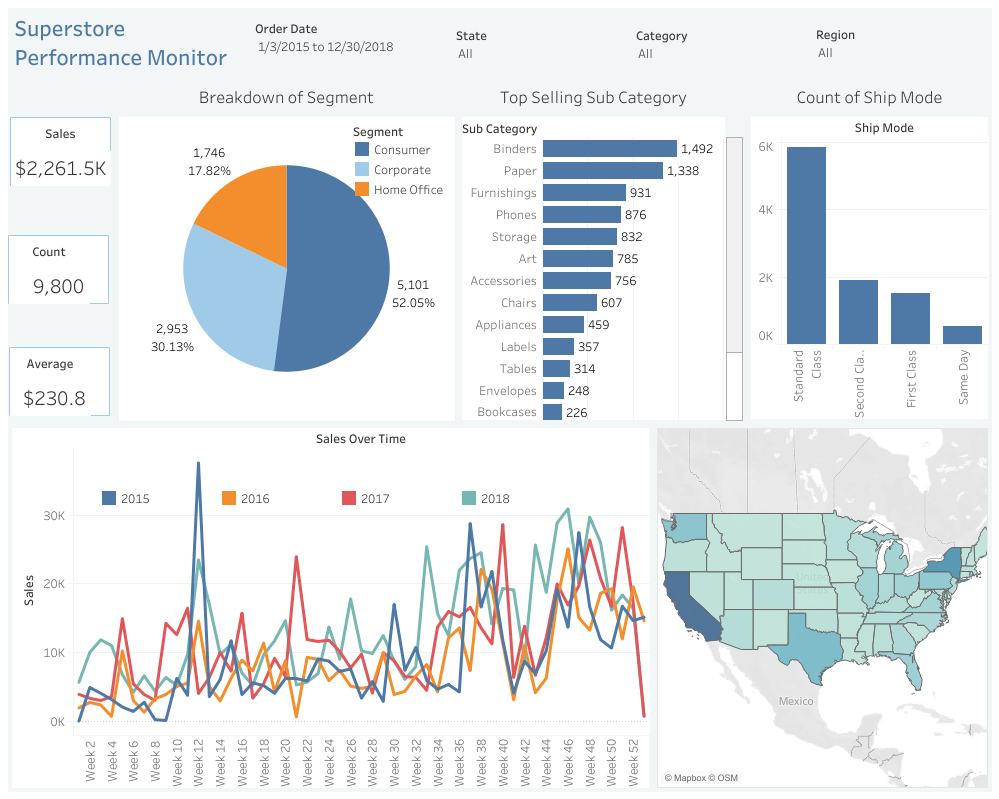